# Dam detection

First iteration of dam detection using Sentinel 2 satellite images and GRanD dam dataset.
The code is inspired by work from a previous [hackathon](https://medium.com/@charlotteweil/can-we-locate-dams-from-space-2a796ac8c04b)


## Initialization 

In [1]:
import tensorflow as tf
tf.enable_eager_execution()

import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib import gridspec
from pprint import pprint
from glob import glob
from tensorflow.keras import layers, activations
from sklearn.model_selection import train_test_split
from itertools import repeat
from collections import Counter
import re

In [4]:

def test(**kwargs):
    print(*kwargs.get('params'))
    print(kwargs.get('params'))
    print(*kwargs.get('params2'))
    print(kwargs.get('params2'))
    
z = {'params': [1, 2, 3],
    'params2': (1,2, 3)}

test(**z)

1 2 3
[1, 2, 3]
1 2 3
(1, 2, 3)


In [60]:
# Constants declaration

# should bridge have a separate label?
BRIDGE_SEPARATE_LABEL = True

# TODO:
# remember that bridges can be under label 0, or label 2
# MAKE A FUNCTION TO PARSE BRIDGES AS LABEL 0
# create first fcnn
# create testing regions

z = {'model': 1, 'model2':3}
r = z['model']
print(r)

1


In [3]:
# Load data paths
# TODO: EDIT THIS SO THAT IT ACCOUNTS FOR POSSIBLY 2 LABEL CHOICES
dams = glob('datasets/data/dams*.gz')[0:10]
bridges = glob('datasets/data/bridge*.gz')[0:10]
other = glob('datasets/data/other*.gz')[0:10]

print("number of TFRecords in dams:", len(dams))
print("number of TFRecords in bridges:", len(bridges))
print("number of TFRecords in other:", len(other))

dams = [[x, 1] for x in dams]
other = [[x, 0] for x in other]

if BRIDGE_SEPARATE_LABEL:
    bridges = [[x, 2] for x in bridges]
else:
    bridges = [[x, 0] for x in bridges]


records = [[data, label] for sublist in [dams, other] for [data, label] in sublist]
labels = [label for data,label in records]
records = [data for data,label in records]

print(labels)
print("number of TFRecords combined:", len(labels))

number of TFRecords in dams: 10
number of TFRecords in bridges: 10
number of TFRecords in other: 10
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
number of TFRecords combined: 20


In [4]:
def visualize_distribution(data):
    string_lst = ['dams', 'other', 'bridges']
    prog = re.compile(r"(?=("+'|'.join(string_lst)+r"))")
    results = np.array([prog.findall(x) for x in data]).flatten()
    
    names = Counter(results).keys() # equals to list(set(words))
    counts = Counter(results).values() # counts the elements' frequency
    
    zipbObj = zip(names, counts)
    # Create a dictionary from zip object
    distribution = dict(zipbObj)
    
    print(distribution)
    centers = range(len(distribution))
    
    plt.bar(distribution.keys(), distribution.values())
    
    return results
    
def split_training_validation_datasets(x, y, val_percentage=0.3, val_balanced='balanced', seed=1):
    """
    Derive a training and a validation datasets from a given dataset with
    data (x) and labels (y). By default, the validation set is 30% of the
    training set, and it has balanced samples across classes. When balancing,
    it takes the 30% of the class with less samples as reference.
    """    
    # define number of samples
    n_samples = x.shape[0]
    
    # make array of indexes of all samples [0, ..., n_samples -1]
    idxs = np.array(range(n_samples))
    
    print("Dataset has " + str(n_samples) + " samples")
    
    # initialize (empty) lists of samples that will be part of training and validation sets 
    tra_idxs = []
    val_idxs = []
    
    # append values to tra_idxs and val_idxs by adding the index of training and validation samples
    # take into account the input parameters 'val_percentage' and 'val_balanced' 
    
    if val_balanced == 'balanced':
        # Get label with least amount of examples, and multiply by val_percentage, then make integer
        subsample_size = int(np.ceil(np.min(np.unique(y,return_counts = True)[1]) * val_percentage))
        # sample all of the remaining classes for the validation set, taking into account class balance
        for label in np.unique(y):
            # Grab indices that have label value temp
            temp = idxs[y == label]
            # append to val_idxs, sample from temp, and account for subsample_size
            # draw without replacement, or else it would not be a split, no copies of data in validation set!
            val_idxs.append(np.random.choice(temp, size=subsample_size, replace=False))
             
        val_idxs = np.asarray(val_idxs).flatten()
        tra_idxs = np.setdiff1d(idxs, val_idxs)  
    elif val_balanced == 'random':
        # do not take into account class imbalance, and take a random sample of the data
        val_idxs = np.random.choice(idxs, size = int(n_samples * val_percentage), replace=False)
        tra_idxs = np.setdiff1d(idxs, val_idxs)
    
    elif val_balanced == 'stratified':
        tra_idxs, val_idxs, y_train, y_test = train_test_split(idxs, y, test_size=val_percentage, stratify = y, random_state=seed)

        
    # print number of samples in training and validation sets
    print('validation samples = {}'.format(len(val_idxs)))
    print('training samples   = {}'.format(len(tra_idxs)))
        
    # define training/validation data and labels as subsets of x and y
    x_train = x[tra_idxs]
    y_train = y[tra_idxs]
    x_validation = x[val_idxs]
    y_validation = y[val_idxs]
    # also return validation indices to be used later
    return x_train, y_train, x_validation, y_validation, val_idxs

Dataset has 20 samples
validation samples = 4
training samples   = 16
Dataset has 16 samples
validation samples = 2
training samples   = 14
X_test is ['datasets/data/dams-6.gz' 'datasets/data/other-8.gz'
 'datasets/data/dams-7.gz' 'datasets/data/other-5.gz']
{'dams': 2, 'other': 2}
Xval is ['datasets/data/other-9.gz' 'datasets/data/dams-3.gz']
{'other': 1, 'dams': 1}


array(['other', 'dams'], dtype='<U5')

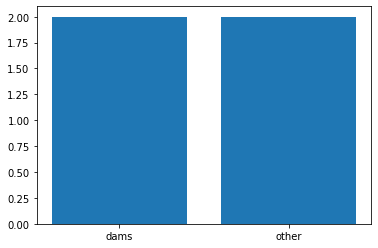

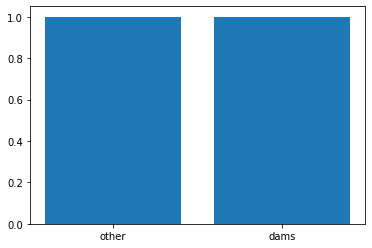

In [5]:
# Train val test split
# based on 0/1 labels, or 0/1/2 labels
# DO NOT USE THE TEMPORARY LABELS DEFINED HERE FOR TRAINING/TESTING

# dataset/test split -> unbalanced as a real world example
temp_data, temp_labels, x_test, y_test, test_idx = split_training_validation_datasets(np.asarray(records), np.array(labels), val_percentage=0.2, val_balanced='stratified')
x_train, y_train, x_val, y_val, val_idx = split_training_validation_datasets(temp_data, temp_labels, val_percentage =0.1, val_balanced='balanced')

# visualize test distribution
print("X_test is", x_test)
visualize_distribution(x_test)

plt.figure()
# visualize validation distribution
print("Xval is", x_val)
visualize_distribution(x_val)

### TF parsing functions

In [148]:
# Tensorflow parse functions

# Parser function, extracted using a .map function

# In normal applications, I guess you would have a single function that does most of the heavy lifting
# but for illustrative purposes, multiple functions are used.
def parse_serialized_example(example_proto):
    ''' Parser function
    Useful for functional extraction, i.e. .map functions
    
    Args:
        example_proto: a serialized example
        
    Returns:
        A dictionary with features, cast to float32
        This returns a dictionary of keys and tensors to which I apply the transformations.
    '''
    # feature columns of interest
    featuresDict = {
        'AVE': tf.io.FixedLenFeature([257, 257], dtype=tf.float32), # Elevation
        'B2': tf.io.FixedLenFeature([257, 257], dtype=tf.float32),  # B
        'B3': tf.io.FixedLenFeature([257, 257], dtype=tf.float32),  # G
        'B4': tf.io.FixedLenFeature([257, 257], dtype=tf.float32),  # R
        'index': tf.io.FixedLenFeature([1], dtype=tf.int64), # index
        'label': tf.io.FixedLenFeature([1], dtype=tf.float32), #label
        'NDWI': tf.io.FixedLenFeature([257, 257], dtype=tf.float32) # vegetation index
    }
    
    return tf.io.parse_single_example(example_proto, featuresDict)



def tf_stretch_image_colorspace(img):
    max_val = tf.reduce_max(img)
    return tf.cast(tf.divide(img, max_val), tf.float32)



#using a closure so we can add extra params to the map function from tf.Dataset
def parse_image(dims = [257, 257], channels = ['B4', 'B3', 'B2'], stretch_colorspace=True):
    ''' Stack individual RGB bands into a N dimensional array
    The RGB bands are still separate 1D arrays in the TFRecords, combine them into a single 3D array
    
    Args:
        features: A dictionary with the features (RGB bands or other channels that need to be concatenated)
    '''
    
    # print("using the general image parsing function")
    def parse_image_fun(features):
        #channels = list(features.values())
        label = features['label']
        
        # get the list of values from the channel names
        list_chan = [features[x] for x in channels]
        
        # stack the individual arrays, remove all redundant dimensions of size 1, and transpose them into the right order
        # (batch size, H, W, channels)
        img = tf.transpose(tf.squeeze(tf.stack(list_chan)))
        
        # stretch color spaces
        if stretch_colorspace:
            img = tf_stretch_image_colorspace(img)
        
        # Additionally, resize the images to a desired size
        img = tf.image.resize(img, dims)
        return img, tf.reduce_max(tf.one_hot(tf.cast(label, dtype=tf.int32), 2, dtype=tf.int32), axis=0) #tf.cast(label, dtype=tf.int32)# 
    
    return parse_image_fun

# label record iterator
def parse_label(features):
    labels = features['label']
    y,_, counts = tf.unique_with_counts(labels)
    return y, counts

#condition to change labels from 2 to 0
# Alternatively, it can be done afterwards by using a lambda function in map:
# x = x.map(lambda x: x[0] if x[0] == 1 else x[1])
# atm no idea which one is faster
# testing the conditional label return functions
def parse_label2(features):
    labels = features['label']
    labels = tf.unstack(tf.cast(labels, dtype = tf.int32))
    x = tf.constant(2)
    
    def f1(): return tf.add(labels, 0)
    def f2(): return tf.add(labels, -2)
    
    print("the labels are")
    r = tf.cond(tf.less(labels[0],x), f1, f2)
    
    return r
    #return tf.reduce_max(tf.one_hot(tf.cast(labels, dtype=tf.int32), 2, dtype=tf.int32), axis=0)

    # testing one hot encodings
def parse_label3(features):
    labels = features['label']   
    return tf.reduce_max(tf.one_hot(tf.cast(labels, dtype=tf.int32), 3, dtype=tf.int32), axis=0)

In [24]:
train_data = tf.data.TFRecordDataset(x_train, compression_type='GZIP')
train_data = train_data.map(parse_serialized_example)
train_data = train_data.map(parse_label3)

for x in train_data:
    print(x)

tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), d

tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), d

tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), d

tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), d

tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), d

tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), d

tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)
tf.Tensor([1 0 0], shape=(3,), d

tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0], shape=(3,), d

## Data exploration
This section will cover some basic data exploration. The idea is to check whether we can get a handle on the TFRecord format, see how it works, and if the data itself has proper characteristics. Furthermore, we can view several of the images as examples, count the label distribution to make the distinction whether we are dealing with a balanced or imbalanced dataset, and possible view several augmentations.   

We will start by simply loading the dataset and printing some basic information about the records inside of the TFRecord datafile.

For simplicity, we will only cover the training data for now. When we are going to train a neural network, we will also consider the validation and testing generators.

In [91]:
# Load the training and testing files
train_data = tf.data.TFRecordDataset(x_train, compression_type='GZIP')
print(train_data)

<TFRecordDatasetV1 shapes: (), types: tf.string>


The code above first loads the dataset and then we map the dataset using the parse_tfrecord function, which returns a dictionary of keys and tensors. As we can see, we have made a connection to the features B2,B3,B4, and class and each of their tensors (values) into a dictionary. Now we can easily extract and transform features from each example. 

The only thing we need to do now is write a function on how these transformations should look like, which we have already done. All that is left is to execute these functions in a similar way as before.

In [92]:
# image parsing function
parsed_record = train_data.map(parse_serialized_example)
# returns the image and label
parsed_image = parsed_record.map(parse_image([257, 257], stretch_colorspace = True))

The parsed_record variable holds similar information as the parse_example earlier, but this time we specify exactly which features we want to have and which ones we do not, and the labels are also passed into the featuresDict instead of being returned as a separate feature. 

The parsed_image variable holds information on what specific transformation we want to apply to the tensors, which is specified in the parse_image_RGB function. Basically, we stack all the individual arrays together to create a single 3D array with shape (257, 257, 3,) which will be a single image. The label is returned separately. We will use this specific object to visualize example images.

Finally, the parsed_label variable will be used to determine the label distribution. For each instance, it counts which label occurs, which is either 0 or 1, and how many times it occurs. Since we are dealing with single examples, it will return 1 as well. 

### Example patches
We can now visualize some of the data hidden inside of the TFRecords. The way this is done is via the parsed_image variable defined above. From this point onwards, the parsed_image variables acts as an iterable, so we can simply loop over it in a for loop, or we can declare it as an iterator by using the iter() function. We will use the latter.

Example patches from the sentinel 2 satellite (RGB channels only)

In [93]:
num_examples = 5
columns = 5
rows = 2

parsed_image_resize_dark = parsed_record.map(parse_image([257, 257], stretch_colorspace = False))

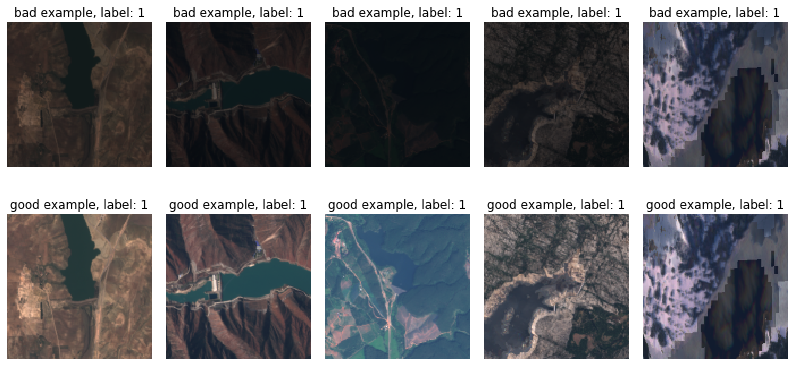

In [162]:
fig = plt.figure(figsize=(columns+8, rows+6))
gs = gridspec.GridSpec(rows, columns,
         wspace=0.1, hspace=0.0, 
         top=1.-0.5/(rows + 1), bottom=0.5/(rows+1), 
         left=0.5/(columns+1), right=1-0.5/(columns+1)) 

parse_iter = iter(parsed_image)
parse_iter_dark = iter(parsed_image_dark)
for j in range(columns):
    image_features, label = parse_iter.next()
    image_features_dark, label_dark = parse_iter_dark.next()

    # bad example: too dark
    ax = plt.subplot(gs[0,j])
    ax.set_title("bad example, label: {}".format(np.argmax(label_dark.numpy())))
    ax.imshow(image_features_dark)
    plt.axis('off')
    
    #good example: stretched colorspace
    ax = plt.subplot(gs[1,j])
    ax.set_title("good example, label: {}".format(np.argmax(label.numpy())))
    
    #uint8 only stores 256 values :/
    img = image_features.numpy()
    ax.imshow(stretch_image_colorspace(image_features))
    plt.axis('off')



The images above are still somewhat dark, and not satisfactory. Upon inspection of the TFRecord stream in the RGB channels I found that the values were somewhere between 0 and 0.02. Assuming that the color space was mapped in between \[0,1\] for all channels, this is very low, and thus it is no wonder that the images appear dark. 

In order to solve this problem we can force the images to use the entire range of possible pixel values by mapping the color space to \[0,255\] and forcing the highest pixel value to 255 itself. The way we can do this is to simply multiple each element in each color channel by 255, and dividing it by the maximum value (out of all the channels). The function that does this is implemented above in the stretch_image_colorspace function.

The results of implementing this change looks something like what is depicted in the lower tiles

### Record counter
The code below is a simple function to count the number of records inside of the TFRecord files. The idea is a basic reduce function that aggregates the unique labels and their counts

In [36]:
# the code state+value reads like a recursion
# the state gets saved and incremented by value (similar to a for loop)
# state by default initializes to 0
# value contains the return argument in the mapped counted labels function
# reduce(np.int64(0), lambda state, value: state + value)

# THIS FUNCTION DOES NOT COMPUTE THE RIGHT NUMBER OF LABEL 1 IF BRIDGES HAS LABEL 2
# ONLY USE THIS WHEN BRIDGES HAS LABEL 0
def count_labels(parser):
    cnt = parser.reduce(np.int64(0), lambda x, y: x + y)
    print("total count is {}".format(cnt[1]))
    print("Total number of examples with label 1 is {}".format(cnt[0]))

parsed_label = parsed_record.map(parse_label, 2)
count_labels(parsed_label)

'''
iterator = iter(parsed_image)

i = 0
while True:
    i +=1
    try:
        iterator.next()
    except tf.errors.InvalidArgumentError:
        print("found error at iteration {}".format(i))
        continue
    except StopIteration:
        break
print("counted {} examples".format(i))
'''
    

total count is [1400]
Total number of examples with label 1 is [700]


'\niterator = iter(parsed_image)\n\ni = 0\nwhile True:\n    i +=1\n    try:\n        iterator.next()\n    except tf.errors.InvalidArgumentError:\n        print("found error at iteration {}".format(i))\n        continue\n    except StopIteration:\n        break\nprint("counted {} examples".format(i))\n'

## Training a Neural network 
We will now illustrate on how to construct a basic neural network using the TFRecord pipeline. We can use the tf.keras api to easily create a keras-like neural network model using generators, constructed from the TFRecords. 
We can use many of the previously defined functions here. We start by first randomizing our dataset, after which we can create/compile our model and train it.


### TFRecord randomization
Before diving into running models with the TFRecord and Tensorflow pipeline, it is good to understand how data from the TFRecord dataset flows through a model. Essentially the data in the records are still in sorted order: first the examples with label 1 are on the top, and the examples with label 0 are at the bottom.

The backpropagation algorithm works best if the (mini)batches examples are in a shuffled and random order. This way, a diverse set of examples are shown to the neural network in each pass. For this reason, shuffling the data is a good idea to improve training speed, which means labels should occur randomly in each batch, e.g. (1,1,0,0,0,0,0,1,0,1,1).

Secondly, we do not want to show the exact same order of the data in each iteration, but rather mix it up so that neural networks sees different combinations of possibly the same data. In order to do this, we must randomize our TFRecord shards. Both the shards themselves, as well as their contents. This is done in the code below. 

An additional notebook is also available that dives deeper into how the randomization process in tensorflow actually works called test_randomization.py. It is inspired by another notebook that can be found [here](https://colab.research.google.com/github/christianmerkwirth/colabs/blob/master/Understanding_Randomization_in_TF_Datasets.ipynb#scrollTo=pS0ihDFTd1uI)

Keep in mind that we basically need 2 generators, one for the training dataset, which needs randomization, and one for the validation/testing data, which does not need randomization.

In [57]:
def random(file_names, train=True):
    files = tf.data.Dataset.list_files(file_names, shuffle=None, seed=None)
    shards = files.shuffle(buffer_size=7)
    
    dataset = shards.interleave(lambda x: tf.data.TFRecordDataset(x, compression_type='GZIP'), 
                                cycle_length=len(file_names), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=3000)
    #dataset = dataset.repeat(4)
    dataset = dataset.map(parse_serialized_example, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(parse_image_RGB, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(1)
    return dataset

def validate(file_names):
    files = tf.data.Dataset.list_files(file_names, shuffle=None, seed=None)
    dataset = tf.data.TFRecordDataset(files, compression_type='GZIP')
    dataset = dataset.map(parse_serialized_example, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(parse_image_RGB, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(100)
    return dataset


## Model training
The previous sections have treated basic handling of TFRecords and data exploration. Now we want to focus on main goal of this notebook, which is creating a classifier that detects dams from satellite images. 

In [58]:
# Load the TFRecord file
train_dataset = random(x_train)
val_dataset = validate(x_val)
test_dataset = validate(x_test)

Tensor("args_6:0", shape=(1,), dtype=float32)
<DatasetV1Adapter shapes: ((?, 257, 257, 3), (?, 3)), types: (tf.float32, tf.int32)>
Tensor("args_6:0", shape=(1,), dtype=float32)
<DatasetV1Adapter shapes: ((?, 257, 257, 3), (?, 3)), types: (tf.float32, tf.int32)>
Tensor("args_6:0", shape=(1,), dtype=float32)
<DatasetV1Adapter shapes: ((?, 257, 257, 3), (?, 3)), types: (tf.float32, tf.int32)>


In [59]:

def create_model(): 
    inputs = tf.keras.Input(shape=(257,257,3 ))
    x = layers.Conv2D(32, (3,3), activation='relu')(inputs)
    x = layers.Conv2D(64, (3,3), activation='relu')(x)
    x = layers.MaxPool2D((2,2))(x)
    x = layers.Conv2D(64, (3,3), activation='relu')(x)
    x = layers.Conv2D(64, (3,3), activation='relu')(x)
    x = layers.MaxPool2D((2,2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Flatten()(x)
    predictions = layers.Dense(3, activation='softmax')(x)

    model = tf.keras.Model(inputs = inputs, outputs=predictions)

    model.compile(optimizer=tf.train.AdamOptimizer(0.0001),
                 loss= 'categorical_crossentropy',
                 metrics=['accuracy'])
    model.summary()
    return model
#preds = model.predict(test_dataset)
x = create_model()

history = x.fit(
    train_dataset.repeat(), 
    epochs=2, 
    steps_per_epoch=200,
    validation_data=val_dataset.repeat(), 
    validation_steps = 100,
    shuffle=True
)


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 257, 257, 3)]     0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 255, 255, 32)      896       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 253, 253, 64)      18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 126, 126, 64)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 124, 124, 64)      36928     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 122, 122, 64)      36928     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 61, 61, 64)        0   

In [60]:
preds = x.predict(test_dataset)
print(preds)

[[0.33140063 0.3872434  0.28135598]
 [0.39064246 0.2769325  0.332425  ]
 [0.3851517  0.2737058  0.34114248]
 ...
 [0.35246813 0.32221517 0.32531676]
 [0.36187923 0.2895167  0.34860405]
 [0.3352603  0.37614512 0.28859457]]


In [66]:
print(np.unique(preds.flatten()))

[1.1439107e-06 1.7816581e-06 2.0403500e-06 ... 9.9985898e-01 9.9987257e-01
 9.9990487e-01]


## Testing and doodling area

## TODO list 26/08/2019
Current to do list is cut into several aspect, namely at the data (implementation), implementation, and reporting areas.
The current version uses the following named data assets (on my personal google account).
1. GRanD_dams_v1_3: A shapefile with near locations of large dams, according to the GRanD v1.3. dataset, which can be found [here](http://globaldamwatch.org/grand/)
2. NoDams: coordinates of locations without dams, but near water bodies. 


### Data

The current dataset as of 23/08/2019 (Google Drive) contains the GRanD v 1.3. dams examples that serve as the positive labels for dam examples, as well as negative examples with samples that are located near water bodies. 
The following things come to mind to extend the dataset:

1. ***Extend non dam examples***: Adding more negative examples such as bridges, more locations near or in water bodies, dense forests, shiny roads, etc. 
2. ***Extend dam examples***: Adding more dam examples can be done by adding the locations of smaller dams, which can be found [here](http://globaldamwatch.org/).
3. ***NDVI data analysis***: A possible way to determine the effect of placing a dam on biodiversity could be to calculate the NDVI in the region before and after a dam was placed, and determine the difference in trend.
4. ***Segmentation/ gold standard labelling***: Several tools exists to create segmentation data which is more valuable. The downside is that it is a lot of manual labour, and multiple people are needed to create annotator agreement examples are [labelbox](https://labelbox.com/), which is a hosted service, or several labelling programs that can be run on your own server and are similar to labelbox, such as [labelme](https://github.com/wkentaro/labelme) or [labeltool](https://github.com/Slava/label-tool). 
5. ***Add watermask data***: Watermasks can help in dam detection as a simple heuristic: if there is no water, there is no dam

### Implementation

The current implementation consists mainly of an experimental pipeline which has to be extended and optimized. The main focus lies on efficient data handling, an augmentation pipeline, reproducibility, and (readable) result creation in the form of graphs and metrics from which inference can be made.

1. ~~***Move data and scripts to server (Ponyland cluster)*** : self explanatory, make use of the more powerful GPU than on my local machine.~~
2. ***Data augmentation pipeline*** :The current implementation does not have any data augmentation. The fact that we are working with TFRecord can make it more difficult to work with data augmentations since no generators with predefined transformation are readily available.
3. ***data preprocessing***: along with data augmentation, the data needs basic preprocessing such as color stretching and normalization, which is a standard method in deep learning 
4. ***Create abstract tuning/model pipeline***: Different classiers and neural network architectures will be tried and finetuned to find the best result. In order to prevent writing a lot of repeated code in many different files, a pipeline will be made from which models can be defined, finetuned, and executed.

***Optional***
1. ***Create a tensorboard/omniboard instance***
2. ***upgrade to TF 2.0*** : working with tf 2.0 seems less of a hassle, but could be done in spare time. The above of creating a tensorboard instance is natively implemented in notebooks then as well.


### Report

## Errors and troubles during pipeline creation

Ofcourse we encountered several difficulties that had to be overcome. In this section we will cover several of these and how these were solved:

1. **Dark images** (in Python): In the notebook we already explained that the way RGB bands google earth engine do not natively render well in Python. In fact, the RGB bands mostly appeared to be in the range of $RGB \in [0,0.2]$. Python ofcourse expects something normalized, or in the range of 0 to 255. We fixed this by casting the values to the range of $[0,255]$ and by forcing the highest pixel value across all bands to have a value of 255. This way, the colorspace was stretched and the images appeared to be much brighter (normal). 

2. **TFRecord errors**: The TFRecord datasets throw several errors. The first one we encountered was the outOfRange error, which simply meant the end of the record had been reached. As this is not an 'actual' error, we ignored this and simply catched the error if necessarry. The second error proved more difficult: when we were first iterating over a larger dataset we had the following InvalidArgumentError:      
   Feature: B2 (data type: float) is required but could not be found. [[{{node ParseSingleExample/ParseSingleExample}}]] [Op:IteratorGetNextSync].   
This meant that for some reason, one of our patches/examples did not have the compulsory B2 band as a data array. At first, this seemed rather arbitrary, since we surely exported this feature. However when plotting the B2 layer on the earth engine map using Map.addLayer(), we found that a large area in china with dams were masked, meaning that there was no information on the B2 layer present, and therefore not exported! We fixed this by setting a larger time period for the Sentinel 2 imageCollection from 2019-01-01 2019-05-01 to a year and a half:  2018-01-01 2019-05-01. 

3. **Exporting data tables in EE**: One of the more frustrating constraints of Google Earth Engine was the limitations on exporting large tables to the drive. It appeared that our first approach using the SampleRegions function was not successful, since the following error was thrown: reduceRegions: computed value too large. Luckily this gave us a hint that sampleRegions was nothing more than a wrapper function for recudeRegions. The way to solve our problem was to use a map function in combination with the reduceRegion function, which does not time out on single examples, which is explained in more detail [in this google doc](https://developers.google.com/earth-engine/debugging#reduceregion-vs-reduceregions). Although it is not incredibly efficient, it does work.

4. **Sparse elevation data (dsm)**: This problem could have been part of the TFRecord errors along with the B2 band problem, but the problem on this band is so severe that it deserves its own bullet point. The DSM data is incredibly sparse and large regions, i.e. Scandinavia are masked, again around dam regions. TO DO: CONTINUE WRITING THIS AFTER SOLUTION IS MADE

5.  **TFRecord randomization and sharding**:
